「Google Colaboratoryの90分セッション切れ対策【自動接続】」  
https://qiita.com/enmaru/items/2770df602dd7778d4ce6  
chromeのアドオン「Auto Refresh」で９０分切れ対策可能！

# system check

In [0]:
!python --version   # 3.6.7
!nvcc --version
print('--------------------')
import torch
print(torch.__version__) # 1.0.0
torch.cuda.is_available() # True

Python 3.6.7
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
--------------------
1.0.0


True

# mount google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pwd
!ls '/content/drive/My Drive/Colab Notebooks'
!ls

/content
ls: cannot access '/content/drive/My Drive/Colab Notebooks': No such file or directory
mnist_root  sample_data


# import modules

In [0]:
# 参考文献：pytorchについて

# PYTORCH DOCUMENTATION
# https://pytorch.org/docs/stable/index.html
# pytorchの公式ドキュメント

In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms

import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt
%matplotlib inline

from collections import OrderedDict
import time
from datetime import datetime, timedelta, timezone #datetimeモジュールの中にdatetime関数が入ってる点に注意

# define input

In [0]:
# データセットの保管先パス
data_root = './cifar10_root'

# transformで参照するデータ前処理の定義。Data Preprocessing。加工やAugmentationなど。
data_preprocess = transforms.Compose([
    #transforms.Pad(padding=2, fill=0, padding_mode='constant'),   # データサイズが32*32なので調整不要
    transforms.ToTensor()
    ])

# データセットの生成
train_dataset = dset.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=data_preprocess
    )

test_dataset = dset.CIFAR10(
    root=data_root,
    train=False,
    download=False,
    transform=data_preprocess
    )

# データセットの中身の確認
print(train_dataset)
print(type(train_dataset))
#print(shape(train_mnist_dataset))
print('----------------')
print(test_dataset)
print(type(test_dataset))
#print(shape(test_mnist_dataset))

# バッチ処理
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=50, shuffle=False)

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: ./cifar10_root
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None
<class 'torchvision.datasets.cifar.CIFAR10'>
----------------
Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: ./cifar10_root
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None
<class 'torchvision.datasets.cifar.CIFAR10'>


torch.Size([3, 32, 32])
torch.float32
(32, 32, 3)
6


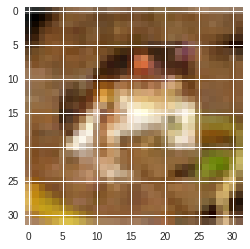

In [0]:
# 「numpyでtensorの余分な次元を除去する」
# https://gokids.hatenablog.com/entry/2017/10/03/223816

# 「Matplotlibで画像を表示」
# https://qiita.com/zaburo/items/5637b424c655b136527a

a, b = train_dataset[0]
print(a.shape)
print(a.dtype)
print(a.numpy().transpose(1,2,0).shape)
plt.imshow(a.numpy().transpose(1,2,0))
print(b)   # ６は蛙

# define model

【初めの検証モデル候補】  
VGGの１１、１３、１６、１９  
それぞれbatch normalizationとdrop outの有無による差を見る。  
訓練回数は15万回程度？  
一番軽いモデルを作って走らせてみて、学習にかかる時間をおおよそで把握し、スケジュールを立てる。

細かい調整をしたくなった際の拡張性を考えると、
nn.Moduleを継承して一度自作してみたいが、  torchvision.modelにていくつかのモデルはパッケージ提供もされている。

torchvision.datasetsからMNIST、  
windowsからImageFolder経由で不織布画像を、  
それぞれ読み込んで、  
両方のデータセットに対して実験結果を溜めていく。

あと、githubについては勉強していくべき。

In [0]:
# 参考文献：クラスの継承について

# python3はpython2流儀でも読める

# https://pytorch.org/docs/stable/nn.html?highlight=nn%20module#torch.nn.Module
# nn.Moduleの公式ドキュメント

# 「Python の super() 関数の使い方」
# https://www.lifewithpython.com/2014/01/python-super-function.html
# superの引数省略に肯定的

# 「Python3 とクラスと super」
# http://d.hatena.ne.jp/shomah4a/20120316/1331864078
# superの引数省略に否定的

# 「【脱オブジェクト指向初心者！】Pythonの継承の基礎を学ぼう」
# https://www.sejuku.net/blog/68040#i
# 一番わかりやすいかも。

# 「python クラスの定義と継承とは」
# http://memopy.hatenadiary.jp/entry/2017/06/10/152057 

# 「Pythonでのクラスの継承とオーバーライド」
# http://www.bokupy.com/detail/20

In [0]:
# 参考文献：Batch Normalizationについて

# 「Deep LearningにおけるBatch Normalizationの理解メモと、実際にその効果を見てみる」
# https://qiita.com/cfiken/items/b477c7878828ebdb0387

# 「Batch Normalization の理解」
# https://qiita.com/t-tkd3a/items/14950dbf55f7a3095600

# 「Batch Normalization と Dropout は併用しない方が良いという話」
# https://10001ideas.com/2018/10/10/batch-normalization-%E3%81%A8-dropout-%E3%81%AF%E4%BD%B5%E7%94%A8%E3%81%97%E3%81%AA%E3%81%84%E6%96%B9%E3%81%8C%E8%89%AF%E3%81%84%E3%81%A8%E3%81%84%E3%81%86%E8%A9%B1/

In [0]:
# 「CNN による画像分類で使われる前処理・テスト時処理まとめ」
# http://iwiwi.hatenadiary.jp/entry/2016/12/31/162059

In [0]:
# 「TensorFlowでVGG19を使ってMNISTのエラー画像一覧を作ってみた」
# https://qiita.com/TokyoMickey/items/a6bbf62571dd79730052

# 「TensorFlow Expertを超えて」
# https://qiita.com/RyuKahou/items/4c66bb3f817fc3a8fc82

# 「PyTorchでのモデルの中間層へのアクセス方法」
# http://nobunaga.hatenablog.jp/entry/2018/09/23/170310

# 「KaggleのMercari Challengeでdeeplearningを駆使して上位10%(Bronze)入り」
# http://www.mirandora.com/?p=2387

In [0]:
# リアルタイムグラフ表示、Colaboratory上だと難しい、、、？

# 「Google Colaboratory上でmatplotlibのアニメーションを再生する」
# http://yaju3d.hatenablog.jp/entry/2018/07/31/234724

In [0]:
# layer definition
class VGG11A(nn.Module):
    
    def __init__(self, num_classes=10):
        super(VGG11A, self).__init__()
        self.features = nn.Sequential(OrderedDict([
            # conv3-64
            ('conv1', nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)),   # チャンネルの扱い注意
            ('relu1', nn.ReLU(inplace=True)),
            ('pool1', nn.MaxPool2d(kernel_size=2, stride=2)),   # 16
            # conv3-128
            ('conv2', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)),
            ('relu2', nn.ReLU(inplace=True)),
            ('pool2', nn.MaxPool2d(kernel_size=2, stride=2)),   # 8
            # conv3-256×2
            ('conv3', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)),
            ('relu3', nn.ReLU(inplace=True)),
            ('conv4', nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)),
            ('relu4', nn.ReLU(inplace=True)),
            ('pool3', nn.MaxPool2d(kernel_size=2, stride=2)),   # 4
            # conv3-512×2
            ('conv5', nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)),
            ('relu5', nn.ReLU(inplace=True)),
            ('conv6', nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)),
            ('relu6', nn.ReLU(inplace=True)),
            ('pool4', nn.MaxPool2d(kernel_size=2, stride=2)),   #2
            # conv3-512×2
            ('conv7', nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)),
            ('relu7', nn.ReLU(inplace=True)),
            ('conv8', nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)),
            ('relu8', nn.ReLU(inplace=True)),
            ('pool5', nn.MaxPool2d(kernel_size=2, stride=2))   #1
        ]))
        
        self.classifier = nn.Sequential(OrderedDict([
            # FC-4096
            ('line1', nn.Linear(512 * 1 * 1, 4096)),
            ('relu9', nn.ReLU(inplace=True)),
            ('drop1', nn.Dropout(p=0.5, inplace=False)),
            # FC-4096
            ('line2', nn.Linear(4096, 4096)),
            ('relu10', nn.ReLU(inplace=True)),
            ('drop2', nn.Dropout(p=0.5, inplace=False)),
            # FC-1000
            ('line3', nn.Linear(4096, 1000)),
            ('relu11', nn.ReLU(inplace=True)),
            ('drop3', nn.Dropout(p=0.5, inplace=False)),
            # FC-num_classes
            ('line4', nn.Linear(1000, num_classes))
        ]))
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

#device = 'cpu'   # debugはこっちの方が分かりやすい
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = VGG11A().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
#
scheduler = None

In [0]:
# 重みパラメータを手動で初期化。
# Heの初期値。
# conv。weightはHeで、biasは0で初期化。
nn.init.kaiming_uniform_(net.features.conv1.weight, mode='fan_in', nonlinearity='relu')
nn.init.constant_(net.features.conv1.bias, 0.0)
nn.init.kaiming_uniform_(net.features.conv2.weight, mode='fan_in', nonlinearity='relu')
nn.init.constant_(net.features.conv2.bias, 0.0)
nn.init.kaiming_uniform_(net.features.conv3.weight, mode='fan_in', nonlinearity='relu')
nn.init.constant_(net.features.conv3.bias, 0.0)
nn.init.kaiming_uniform_(net.features.conv4.weight, mode='fan_in', nonlinearity='relu')
nn.init.constant_(net.features.conv4.bias, 0.0)
nn.init.kaiming_uniform_(net.features.conv5.weight, mode='fan_in', nonlinearity='relu')
nn.init.constant_(net.features.conv5.bias, 0.0)
nn.init.kaiming_uniform_(net.features.conv6.weight, mode='fan_in', nonlinearity='relu')
nn.init.constant_(net.features.conv6.bias, 0.0)
nn.init.kaiming_uniform_(net.features.conv7.weight, mode='fan_in', nonlinearity='relu')
nn.init.constant_(net.features.conv7.bias, 0.0)
nn.init.kaiming_uniform_(net.features.conv8.weight, mode='fan_in', nonlinearity='relu')
nn.init.constant_(net.features.conv8.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.

In [0]:
print(net)
for name, param in net.named_parameters():
    print(name)
    print(param)

VGG11A(
  (features): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU(inplace)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace)
    (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu4): ReLU(inplace)
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu5): ReLU(inplace)
    (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu6): ReLU(inplace)
    (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0,

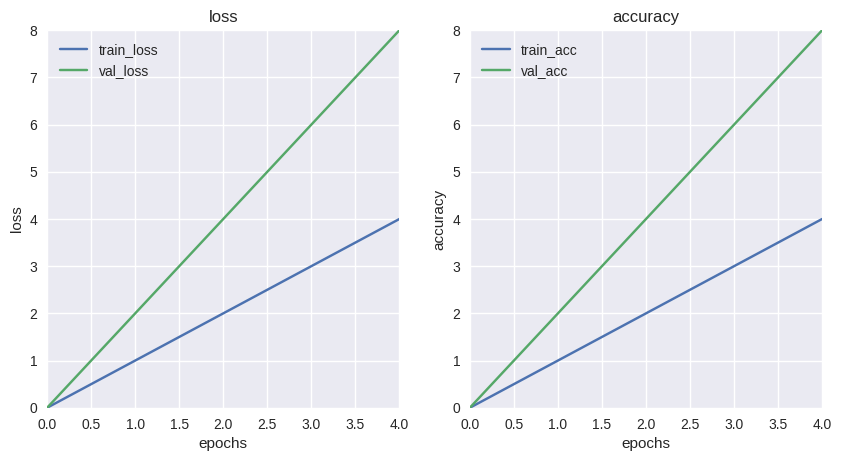

In [0]:
# https://qiita.com/skotaro/items/08dc0b8c5704c94eafb9

# グラフ表示関数の定義

def show_figure(x,y1,y2,y3,y4):   
    # 新しいウィンドウの作成
    plt.close()
    fig1 = plt.figure(1, figsize=(10,5),dpi=100)
    
    # ax1の入力
    ax1 = fig1.add_subplot(1,2,1)
    ax1.plot(x, y1, label='train_loss')   # リストが返ってくるので代入時は注意
    ax1.plot(x, y2, label='val_loss')
    ax1.set_xlim(min(x), max(x))
    ax1.set_ylim(min(min(y1),min(y2)), max(max(y1),max(y2)))
    ax1.grid(True)
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('loss')
    ax1.set_title('loss')
    ax1.legend()
    
    # ax2の入力
    ax2 = fig1.add_subplot(1,2,2)
    ax2.plot(x, y3, label='train_acc')
    ax2.plot(x, y4, label='val_acc')
    ax2.set_xlim(min(x), max(x))
    ax2.set_ylim(min(min(y3),min(y4)), max(max(y3),max(y4)))
    ax2.grid(True)
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('accuracy')
    ax2.set_title('accuracy')
    ax2.legend()
    
    plt.show()

# check====================
ilist = []

epochs = 10
y1 = [0,1,2,3,4]
y2 = [0,2,4,6,8]


show_figure(y1,y1,y2,y1,y2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1, right=1
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1, right=1


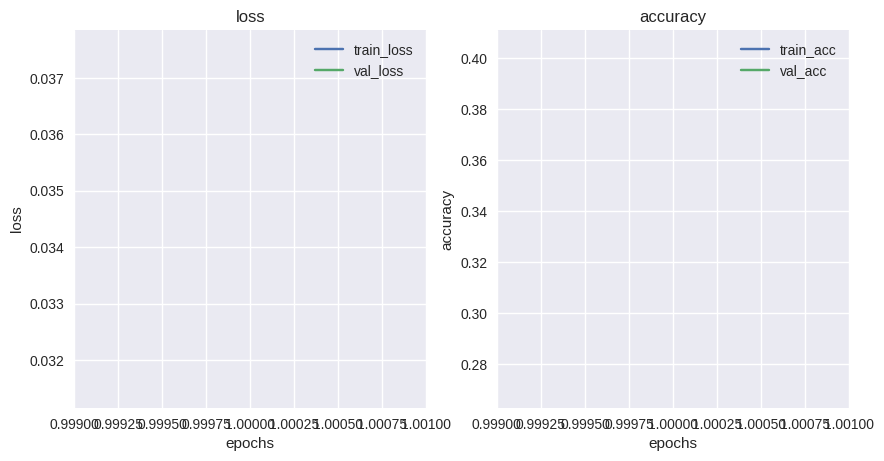

epoch:1
train_acc:13142
val_acc:4111
avg_train_loss:0.03784522154569626
avg_val_loss:0.03115671396255493
avg_train_acc:0.26284
avg_val_acc:0.4111
1epoch_time:67.61098003387451[sec]


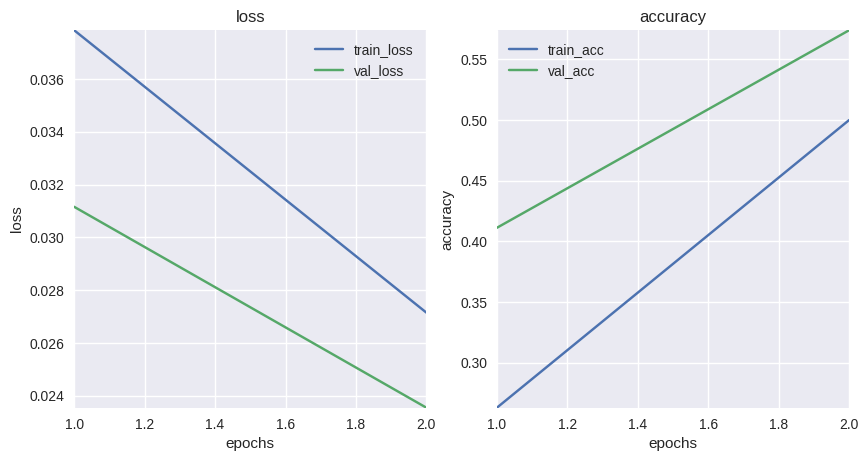

epoch:2
train_acc:24995
val_acc:5739
avg_train_loss:0.027146856646537782
avg_val_loss:0.023545830380916597
avg_train_acc:0.4999
avg_val_acc:0.5739
1epoch_time:68.05797362327576[sec]


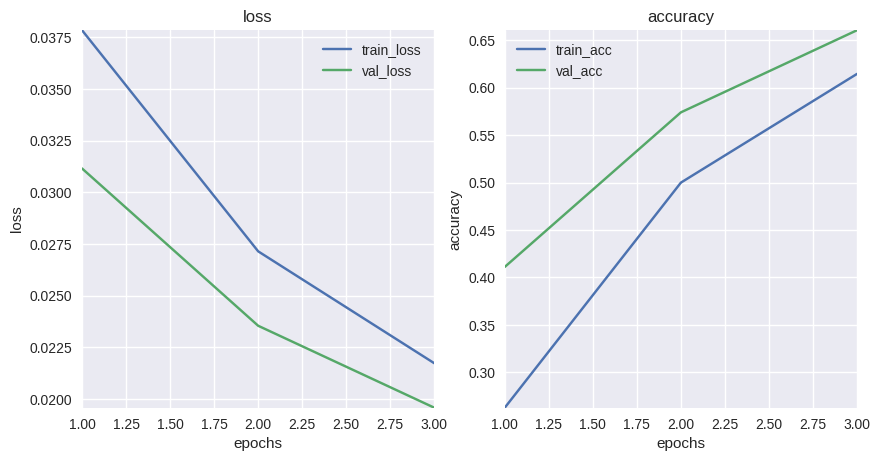

epoch:3
train_acc:30721
val_acc:6604
avg_train_loss:0.02173199285030365
avg_val_loss:0.01958003678917885
avg_train_acc:0.61442
avg_val_acc:0.6604
1epoch_time:67.66334295272827[sec]


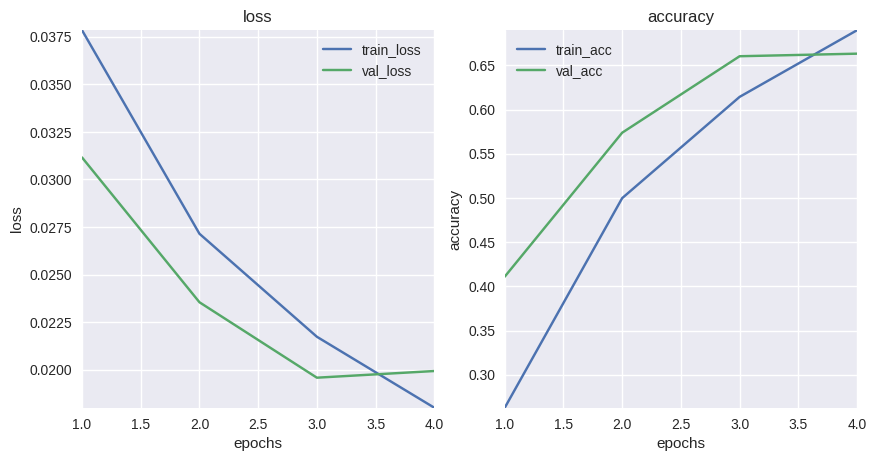

epoch:4
train_acc:34491
val_acc:6633
avg_train_loss:0.01800158577978611
avg_val_loss:0.019930613851547242
avg_train_acc:0.68982
avg_val_acc:0.6633
1epoch_time:67.73686408996582[sec]


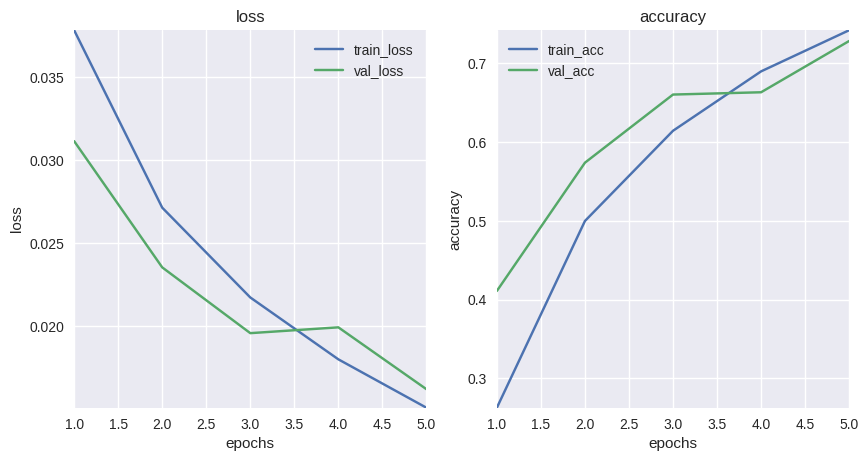

epoch:5
train_acc:37103
val_acc:7284
avg_train_loss:0.015083892846107482
avg_val_loss:0.016200620236992837
avg_train_acc:0.74206
avg_val_acc:0.7284
1epoch_time:67.80065655708313[sec]


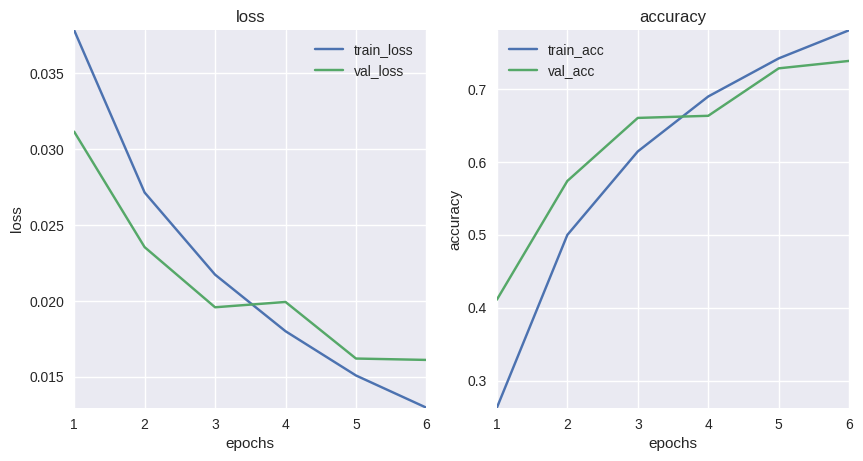

epoch:6
train_acc:39035
val_acc:7386
avg_train_loss:0.012958041354715824
avg_val_loss:0.016109333232045175
avg_train_acc:0.7807
avg_val_acc:0.7386
1epoch_time:67.71669411659241[sec]


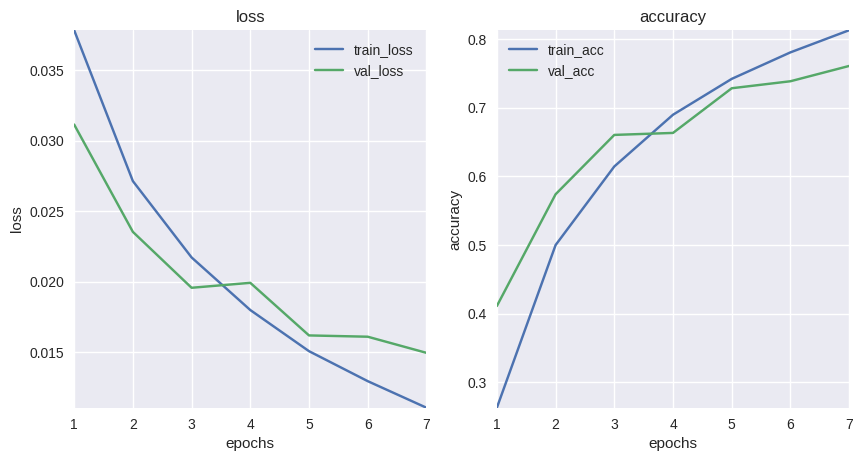

epoch:7
train_acc:40648
val_acc:7609
avg_train_loss:0.0110735373082757
avg_val_loss:0.014966073296964168
avg_train_acc:0.81296
avg_val_acc:0.7609
1epoch_time:67.72336959838867[sec]


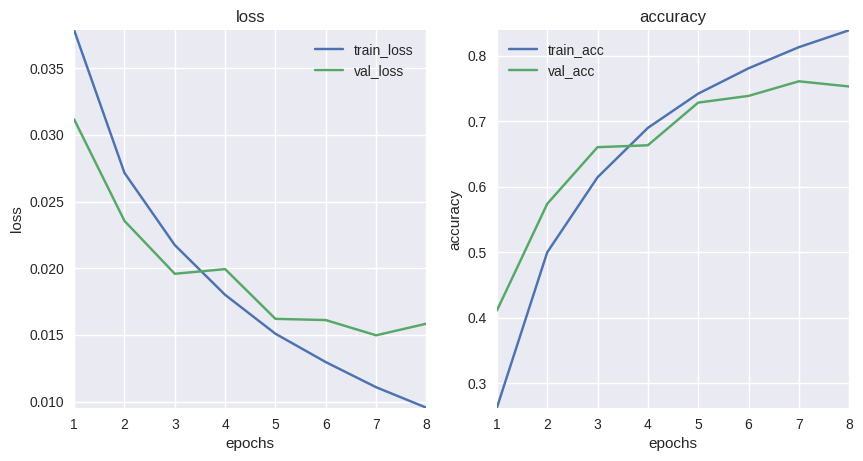

epoch:8
train_acc:41942
val_acc:7530
avg_train_loss:0.009536335881352425
avg_val_loss:0.015837937706708907
avg_train_acc:0.83884
avg_val_acc:0.753
1epoch_time:67.64435148239136[sec]


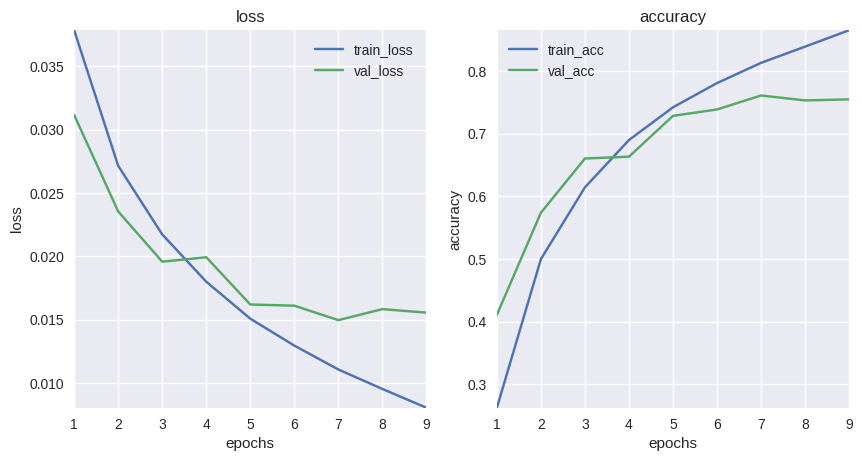

epoch:9
train_acc:43249
val_acc:7547
avg_train_loss:0.00805615352064371
avg_val_loss:0.015557812997698784
avg_train_acc:0.86498
avg_val_acc:0.7547
1epoch_time:67.8757336139679[sec]


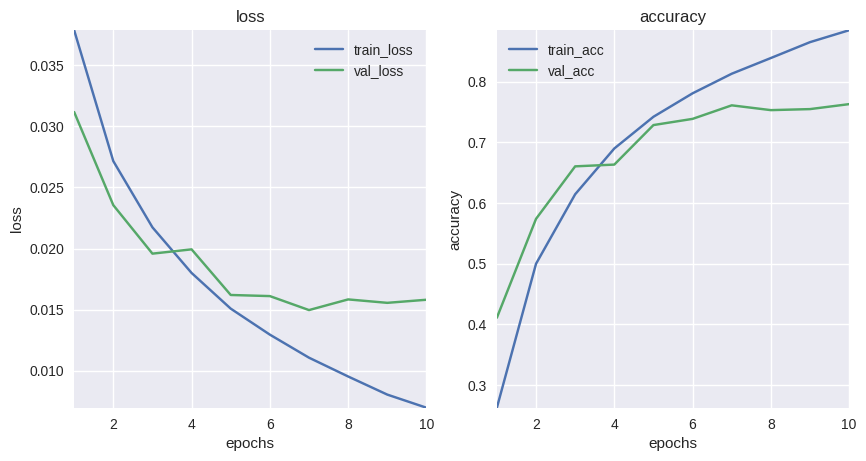

epoch:10
train_acc:44231
val_acc:7629
avg_train_loss:0.006983188511580229
avg_val_loss:0.015810242280364036
avg_train_acc:0.88462
avg_val_acc:0.7629
1epoch_time:68.14269018173218[sec]


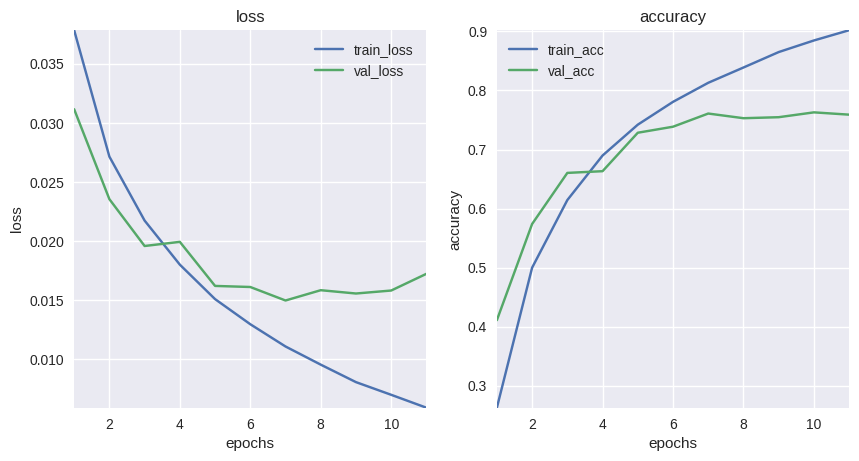

epoch:11
train_acc:45098
val_acc:7590
avg_train_loss:0.005889973563551903
avg_val_loss:0.017226490005850793
avg_train_acc:0.90196
avg_val_acc:0.759
1epoch_time:68.02200675010681[sec]


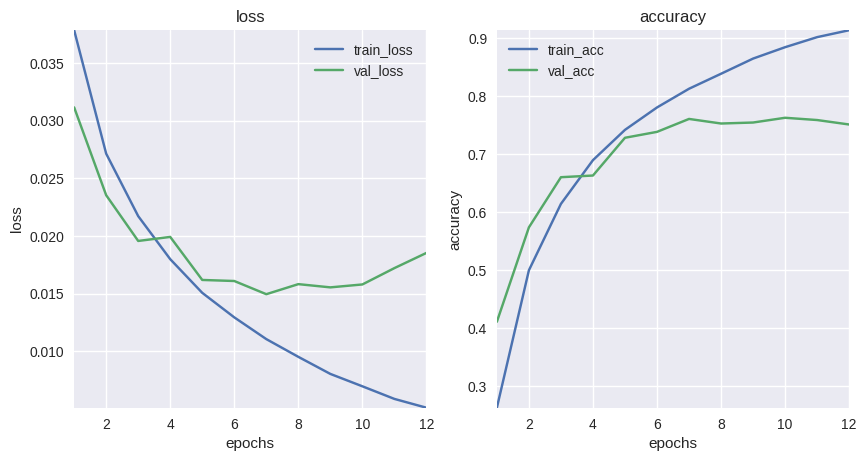

epoch:12
train_acc:45695
val_acc:7513
avg_train_loss:0.005126450900733471
avg_val_loss:0.018544183821976184
avg_train_acc:0.9139
avg_val_acc:0.7513
1epoch_time:68.0171411037445[sec]


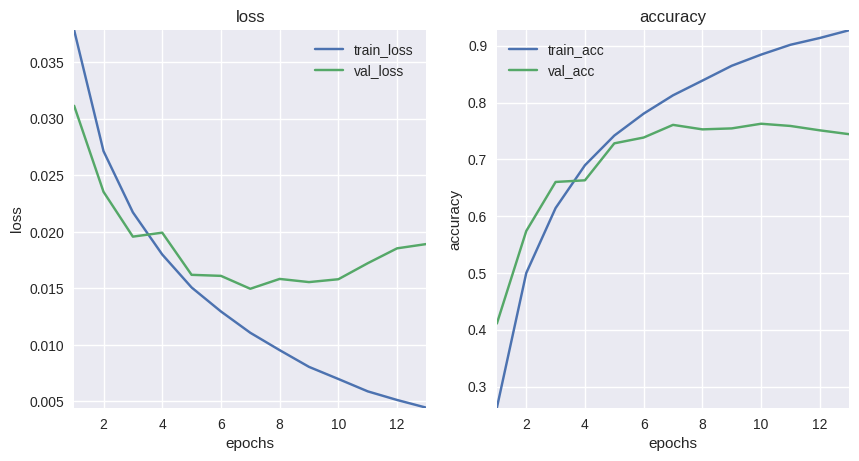

epoch:13
train_acc:46379
val_acc:7445
avg_train_loss:0.004441029140464962
avg_val_loss:0.018925300878286363
avg_train_acc:0.92758
avg_val_acc:0.7445
1epoch_time:67.95480513572693[sec]


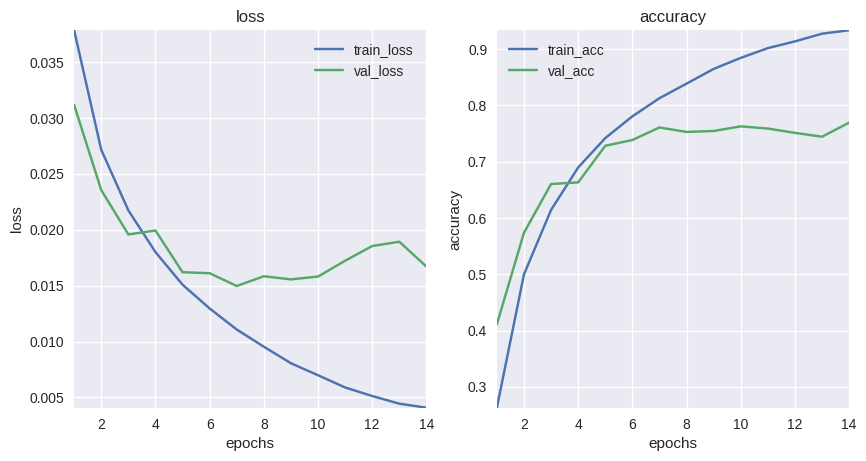

epoch:14
train_acc:46688
val_acc:7696
avg_train_loss:0.004078972506895661
avg_val_loss:0.01670442594587803
avg_train_acc:0.93376
avg_val_acc:0.7696
1epoch_time:68.09356546401978[sec]


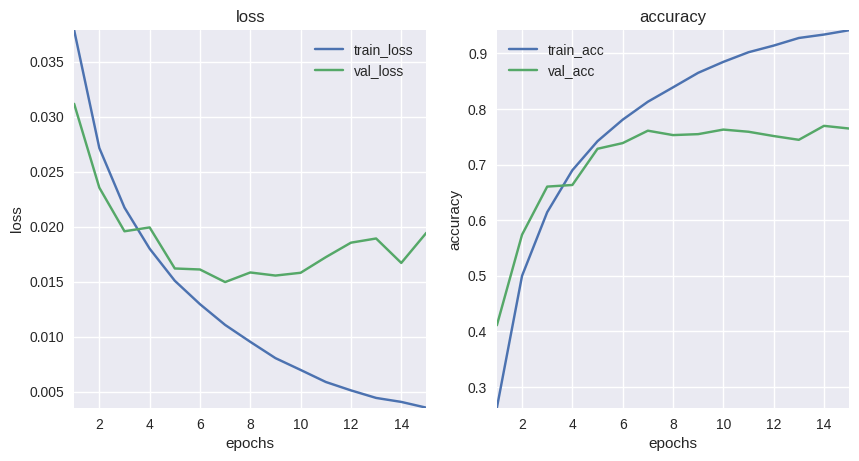

epoch:15
train_acc:47077
val_acc:7648
avg_train_loss:0.0035508917832560837
avg_val_loss:0.019447897241264583
avg_train_acc:0.94154
avg_val_acc:0.7648
1epoch_time:68.04030752182007[sec]


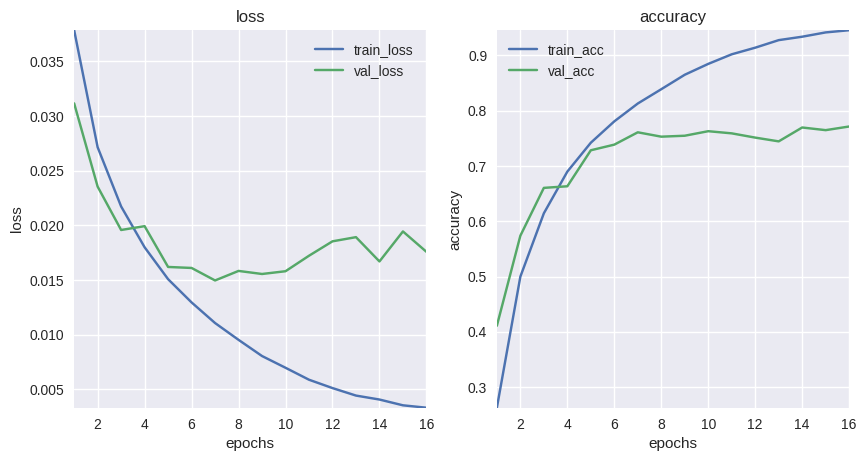

epoch:16
train_acc:47275
val_acc:7714
avg_train_loss:0.003330356336068362
avg_val_loss:0.01758440030515194
avg_train_acc:0.9455
avg_val_acc:0.7714
1epoch_time:68.10565614700317[sec]


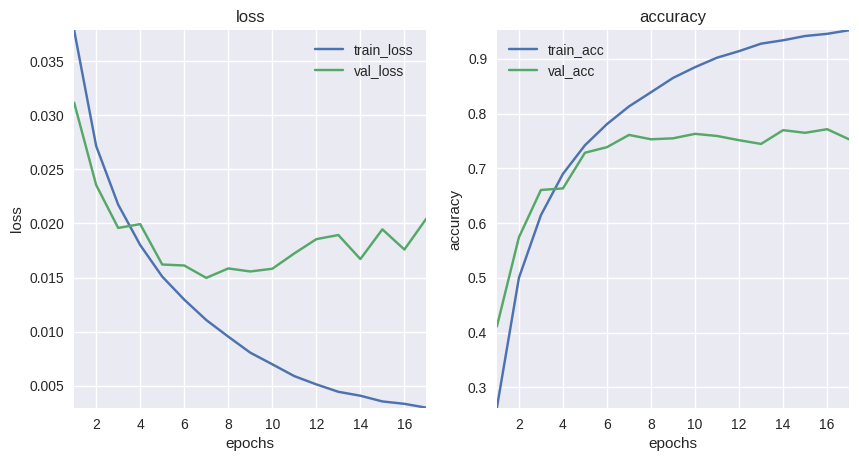

epoch:17
train_acc:47605
val_acc:7528
avg_train_loss:0.002970395085858181
avg_val_loss:0.020452887757122517
avg_train_acc:0.9521
avg_val_acc:0.7528
1epoch_time:68.03332781791687[sec]


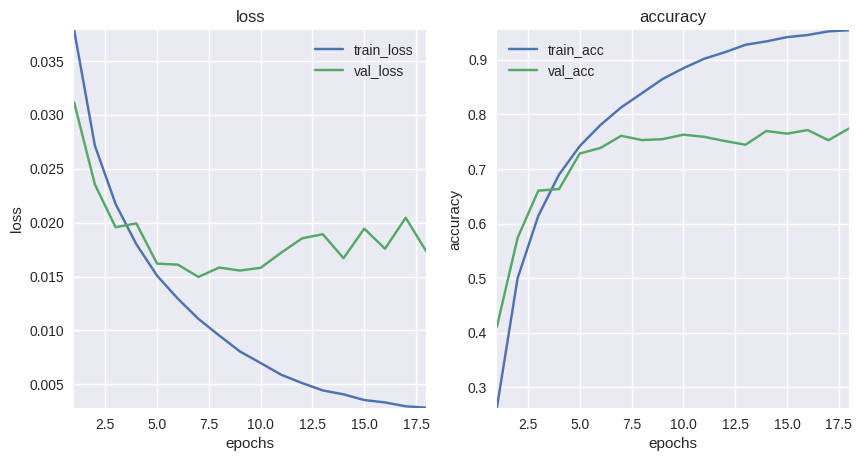

epoch:18
train_acc:47711
val_acc:7744
avg_train_loss:0.002837877849927172
avg_val_loss:0.017316732612252236
avg_train_acc:0.95422
avg_val_acc:0.7744
1epoch_time:68.1077139377594[sec]


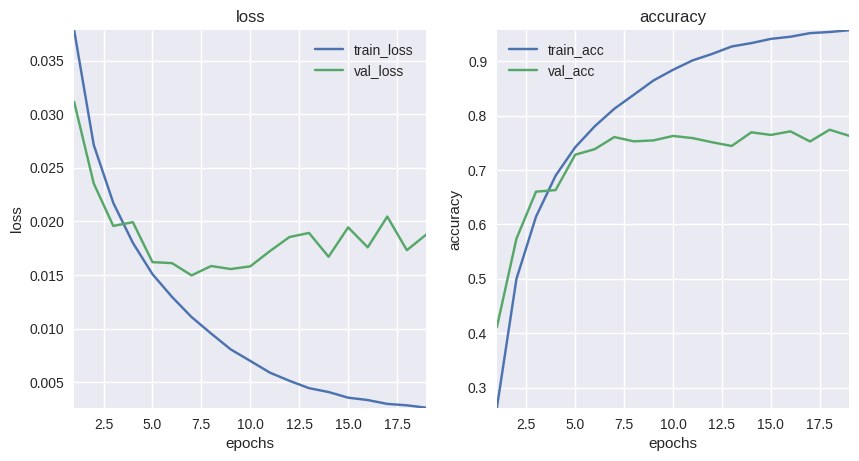

epoch:19
train_acc:47874
val_acc:7632
avg_train_loss:0.0026139421346504242
avg_val_loss:0.018789556846022605
avg_train_acc:0.95748
avg_val_acc:0.7632
1epoch_time:68.18385910987854[sec]


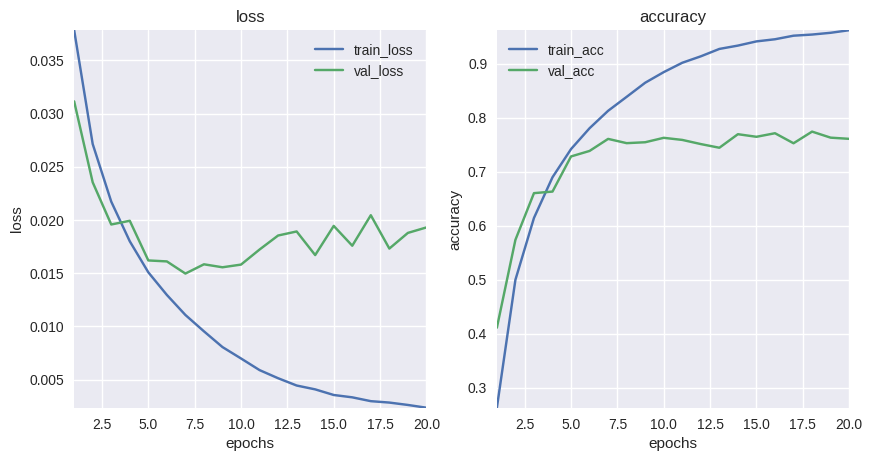

epoch:20
train_acc:48112
val_acc:7610
avg_train_loss:0.002353640211634338
avg_val_loss:0.019304296174645425
avg_train_acc:0.96224
avg_val_acc:0.761
1epoch_time:68.21158695220947[sec]


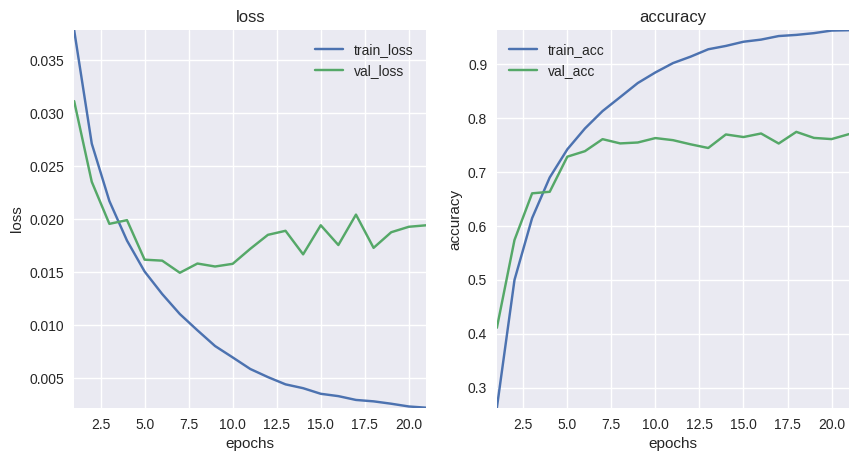

epoch:21
train_acc:48145
val_acc:7703
avg_train_loss:0.0022367378415819256
avg_val_loss:0.019448225125670432
avg_train_acc:0.9629
avg_val_acc:0.7703
1epoch_time:68.17043900489807[sec]


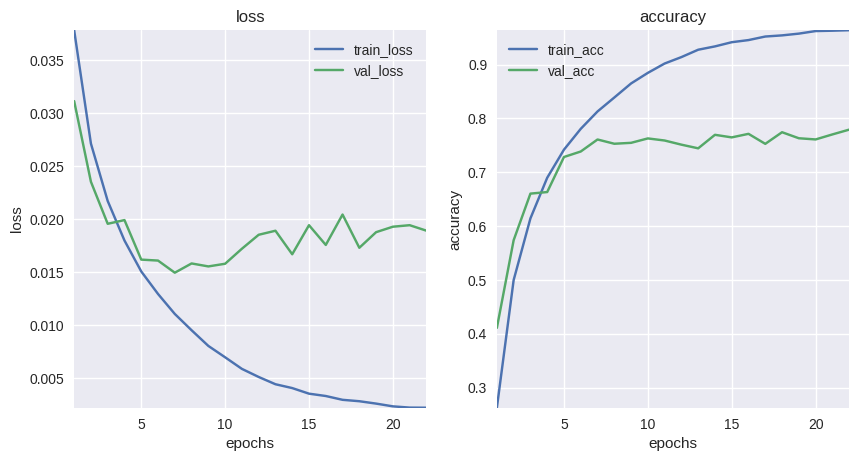

epoch:22
train_acc:48190
val_acc:7792
avg_train_loss:0.0022249355020560325
avg_val_loss:0.018930231422185896
avg_train_acc:0.9638
avg_val_acc:0.7792
1epoch_time:67.96000075340271[sec]


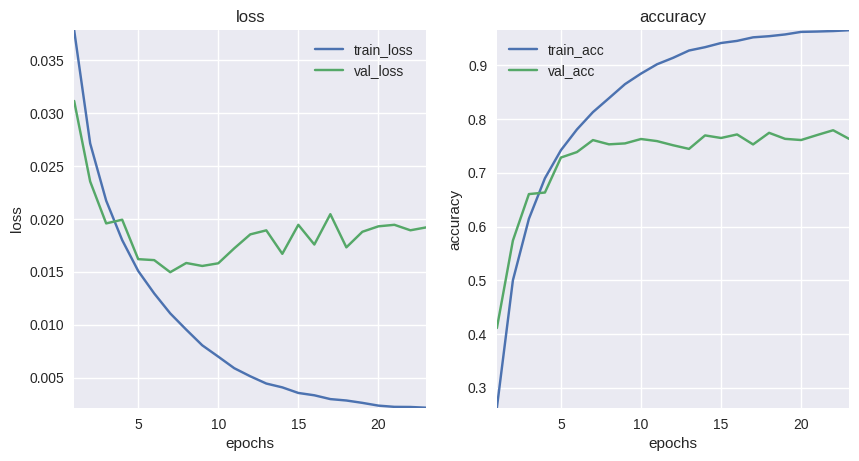

epoch:23
train_acc:48267
val_acc:7631
avg_train_loss:0.00215500003408175
avg_val_loss:0.019208874382078647
avg_train_acc:0.96534
avg_val_acc:0.7631
1epoch_time:68.02687454223633[sec]


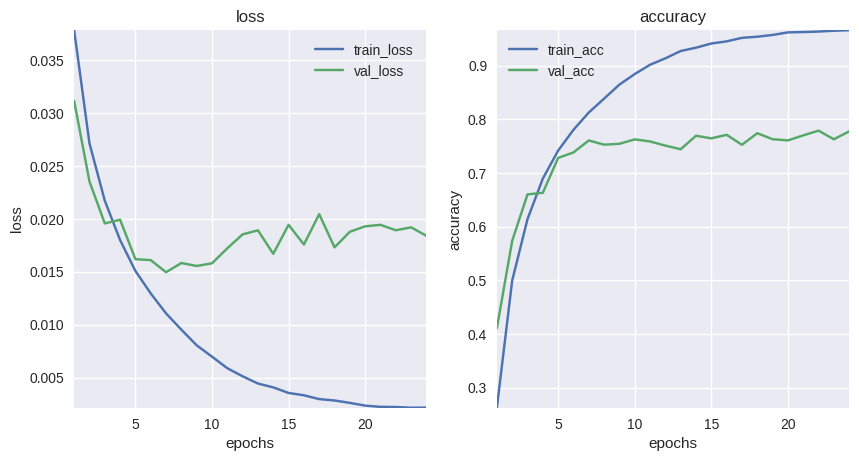

epoch:24
train_acc:48315
val_acc:7778
avg_train_loss:0.002167853244487196
avg_val_loss:0.01841020569503307
avg_train_acc:0.9663
avg_val_acc:0.7778
1epoch_time:68.15073013305664[sec]


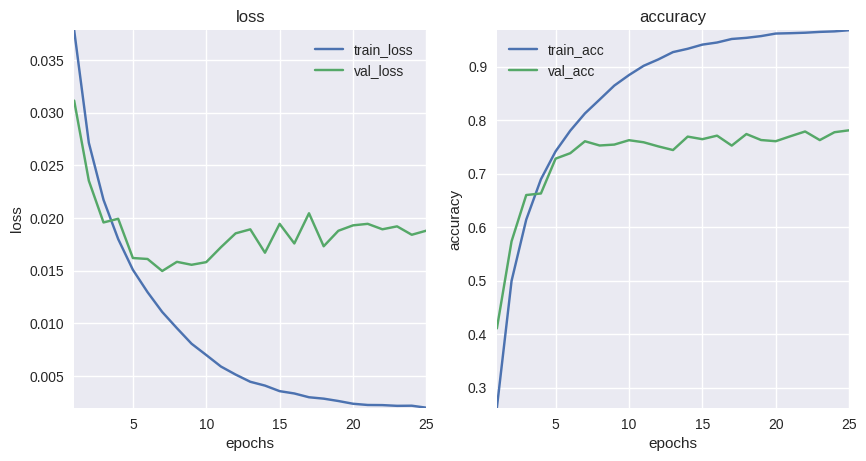

epoch:25
train_acc:48423
val_acc:7814
avg_train_loss:0.0019762570746429263
avg_val_loss:0.01880227929800749
avg_train_acc:0.96846
avg_val_acc:0.7814
1epoch_time:68.10356092453003[sec]


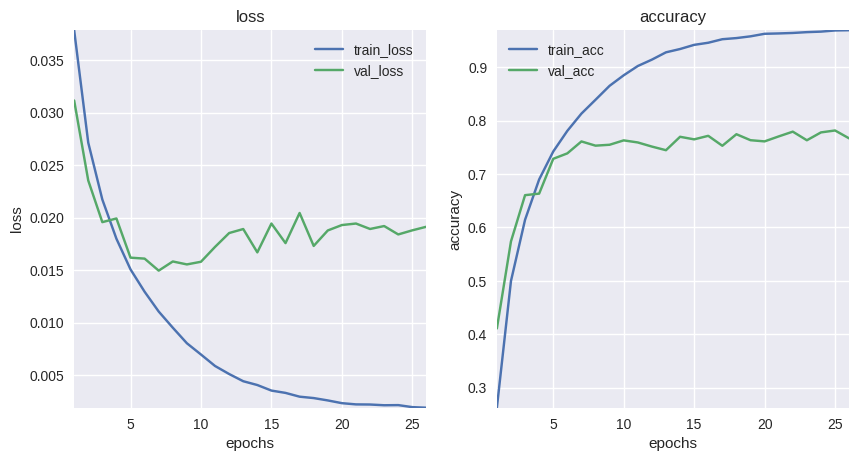

epoch:26
train_acc:48446
val_acc:7666
avg_train_loss:0.0019197006795345806
avg_val_loss:0.019143636791408063
avg_train_acc:0.96892
avg_val_acc:0.7666
1epoch_time:67.99596500396729[sec]


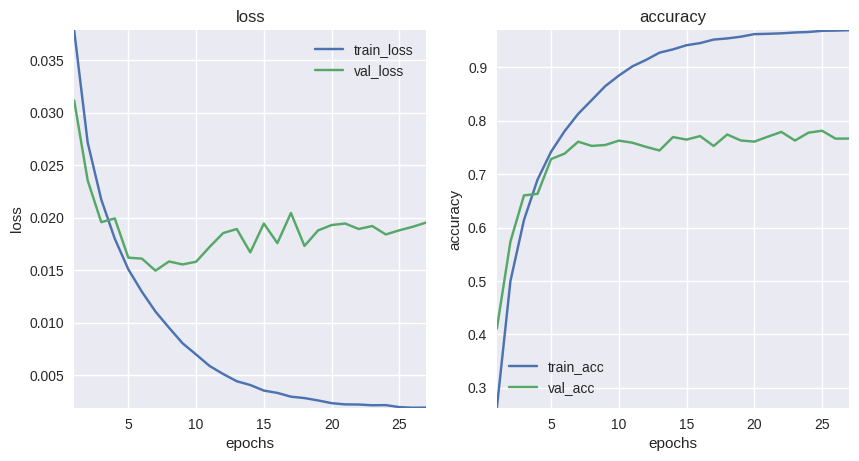

epoch:27
train_acc:48480
val_acc:7668
avg_train_loss:0.0019318419701885431
avg_val_loss:0.019550053238868714
avg_train_acc:0.9696
avg_val_acc:0.7668
1epoch_time:68.12032866477966[sec]


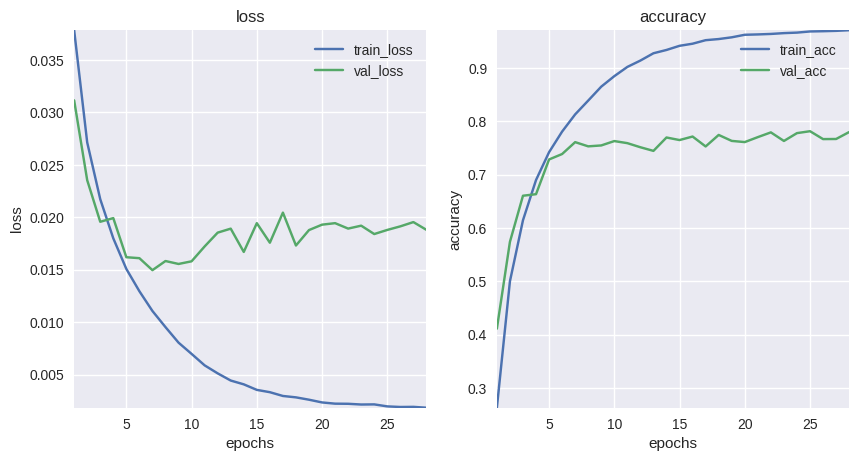

epoch:28
train_acc:48539
val_acc:7798
avg_train_loss:0.0018497080706246197
avg_val_loss:0.018810527113080025
avg_train_acc:0.97078
avg_val_acc:0.7798
1epoch_time:68.18047261238098[sec]


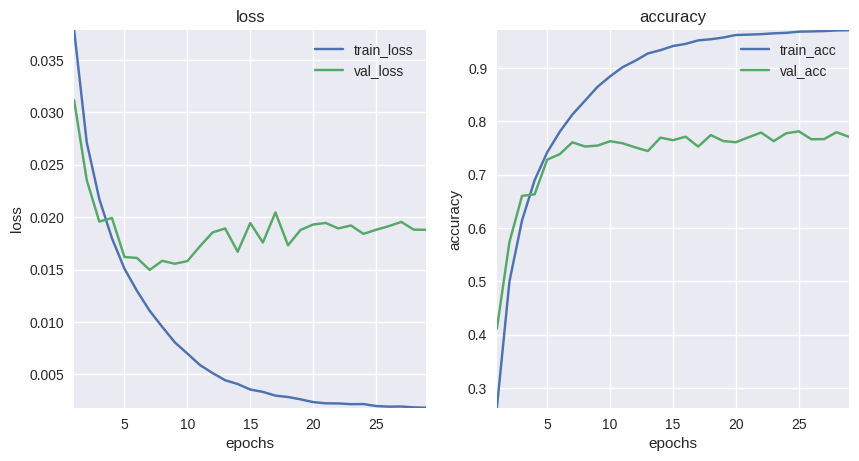

epoch:29
train_acc:48559
val_acc:7710
avg_train_loss:0.001816558947172016
avg_val_loss:0.01879532795250416
avg_train_acc:0.97118
avg_val_acc:0.771
1epoch_time:68.21723628044128[sec]


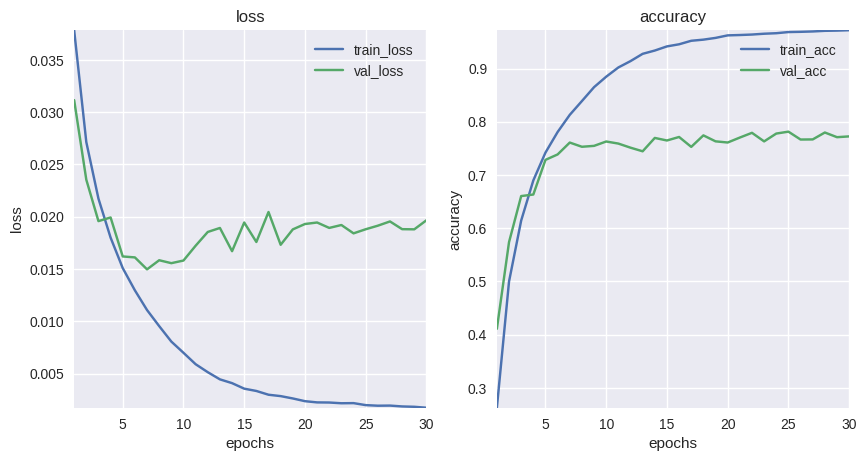

epoch:30
train_acc:48596
val_acc:7725
avg_train_loss:0.0017274443832598627
avg_val_loss:0.01966213389635086
avg_train_acc:0.97192
avg_val_acc:0.7725
1epoch_time:68.15987873077393[sec]


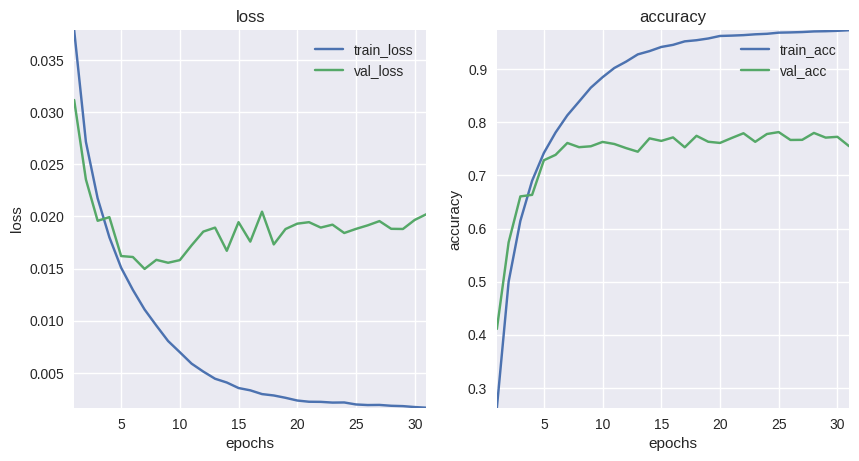

epoch:31
train_acc:48652
val_acc:7548
avg_train_loss:0.0016635411610710434
avg_val_loss:0.020214254900813102
avg_train_acc:0.97304
avg_val_acc:0.7548
1epoch_time:68.09105277061462[sec]


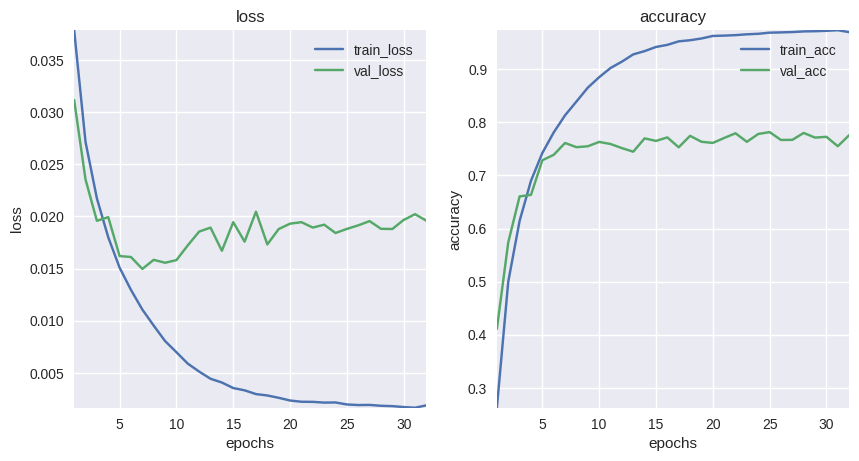

epoch:32
train_acc:48475
val_acc:7756
avg_train_loss:0.0018937698302976787
avg_val_loss:0.01958392715007067
avg_train_acc:0.9695
avg_val_acc:0.7756
1epoch_time:68.36938905715942[sec]


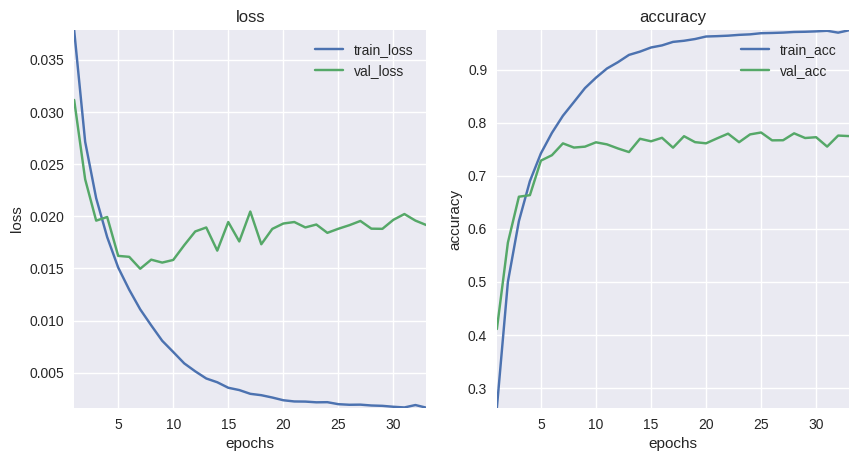

epoch:33
train_acc:48704
val_acc:7746
avg_train_loss:0.001636519251554273
avg_val_loss:0.0191527261197567
avg_train_acc:0.97408
avg_val_acc:0.7746
1epoch_time:68.23739862442017[sec]


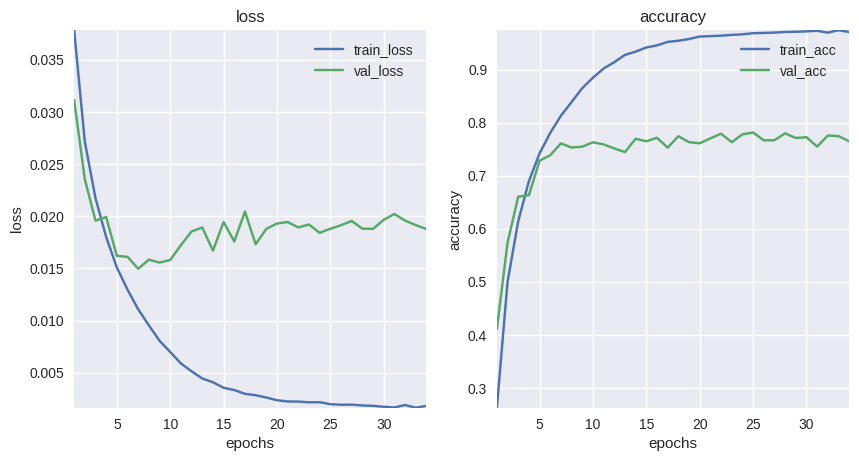

epoch:34
train_acc:48540
val_acc:7648
avg_train_loss:0.0018141558723524212
avg_val_loss:0.018773718950152396
avg_train_acc:0.9708
avg_val_acc:0.7648
1epoch_time:67.9875054359436[sec]


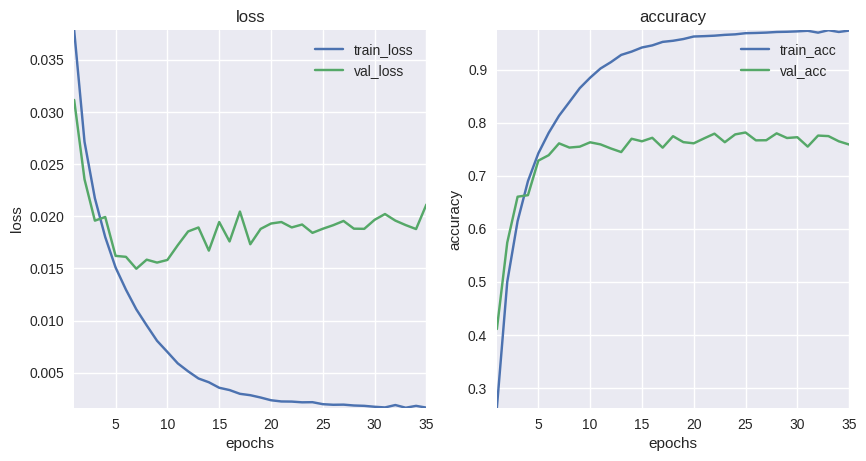

epoch:35
train_acc:48671
val_acc:7587
avg_train_loss:0.001644197288202122
avg_val_loss:0.021128911289572717
avg_train_acc:0.97342
avg_val_acc:0.7587
1epoch_time:67.96055197715759[sec]


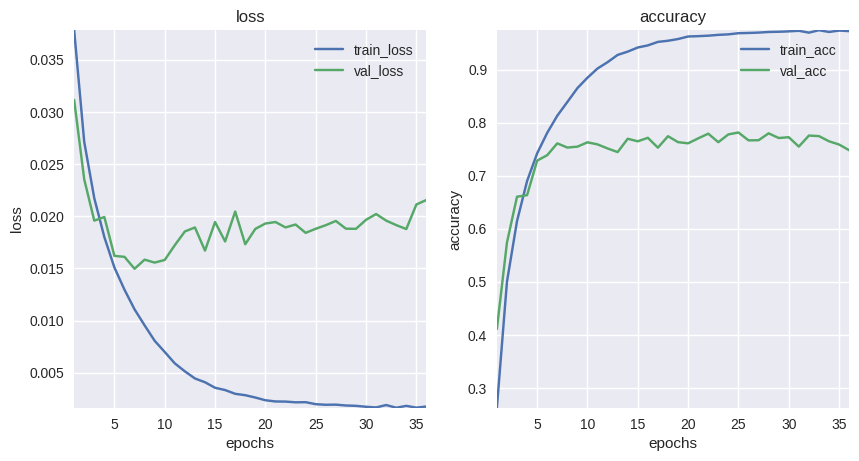

epoch:36
train_acc:48620
val_acc:7480
avg_train_loss:0.001751112149609253
avg_val_loss:0.02156474351286888
avg_train_acc:0.9724
avg_val_acc:0.748
1epoch_time:68.18035197257996[sec]


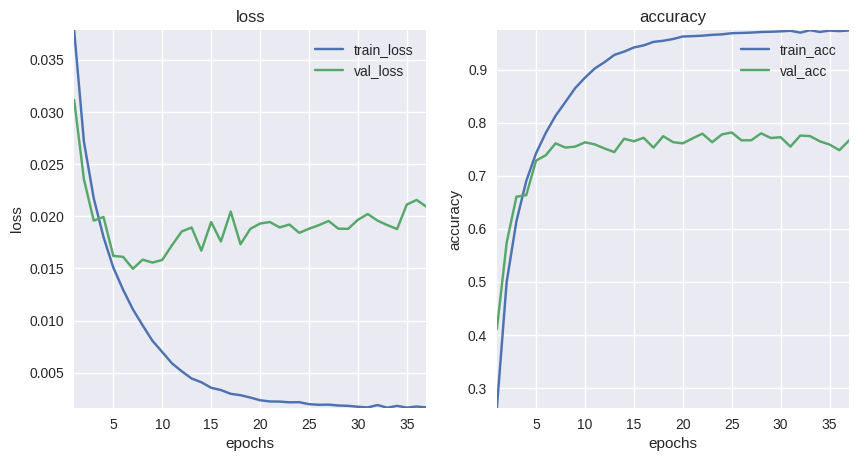

epoch:37
train_acc:48680
val_acc:7667
avg_train_loss:0.0016598683564923705
avg_val_loss:0.02091352106332779
avg_train_acc:0.9736
avg_val_acc:0.7667
1epoch_time:67.77522420883179[sec]


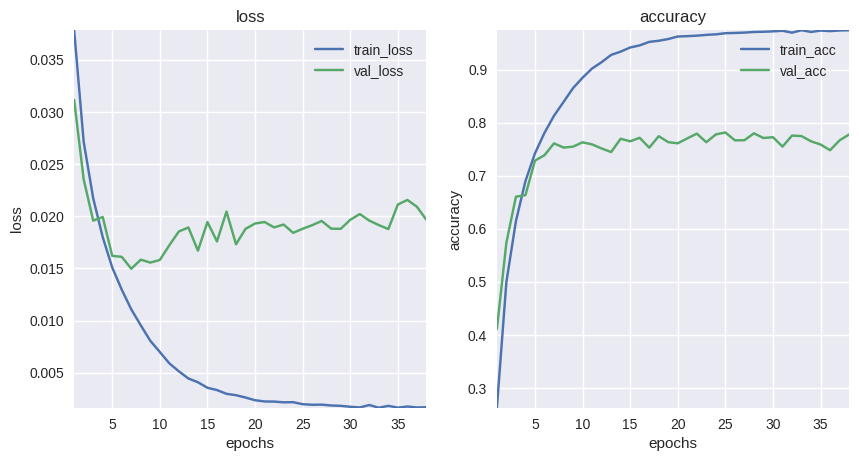

epoch:38
train_acc:48700
val_acc:7777
avg_train_loss:0.001681820145188831
avg_val_loss:0.019655828601121902
avg_train_acc:0.974
avg_val_acc:0.7777
1epoch_time:67.18395137786865[sec]


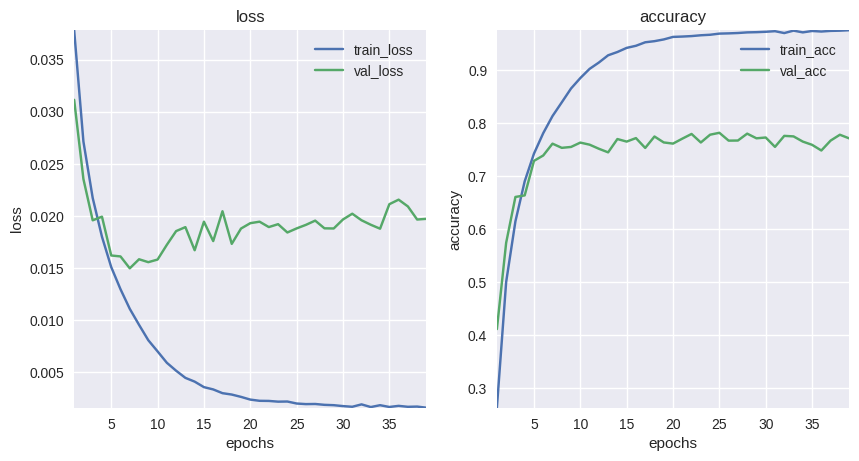

epoch:39
train_acc:48743
val_acc:7709
avg_train_loss:0.0015723706978186965
avg_val_loss:0.019722575891017915
avg_train_acc:0.97486
avg_val_acc:0.7709
1epoch_time:66.97087502479553[sec]


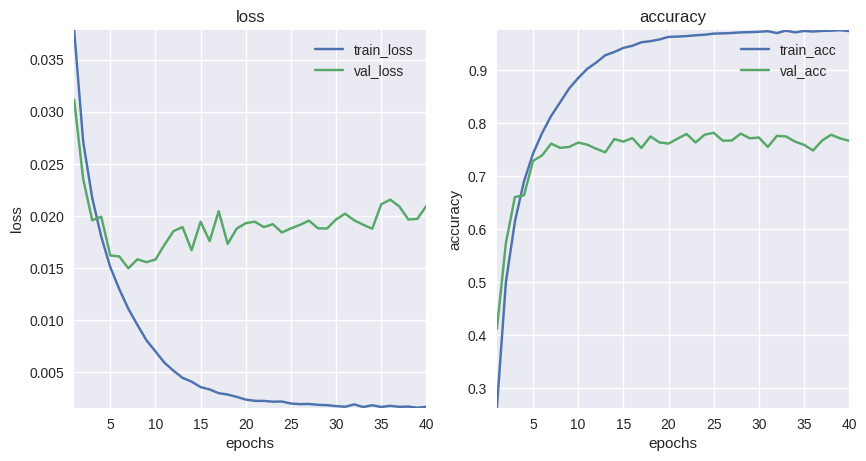

epoch:40
train_acc:48659
val_acc:7662
avg_train_loss:0.0016643213931145148
avg_val_loss:0.020976554504036904
avg_train_acc:0.97318
avg_val_acc:0.7662
1epoch_time:66.89725852012634[sec]


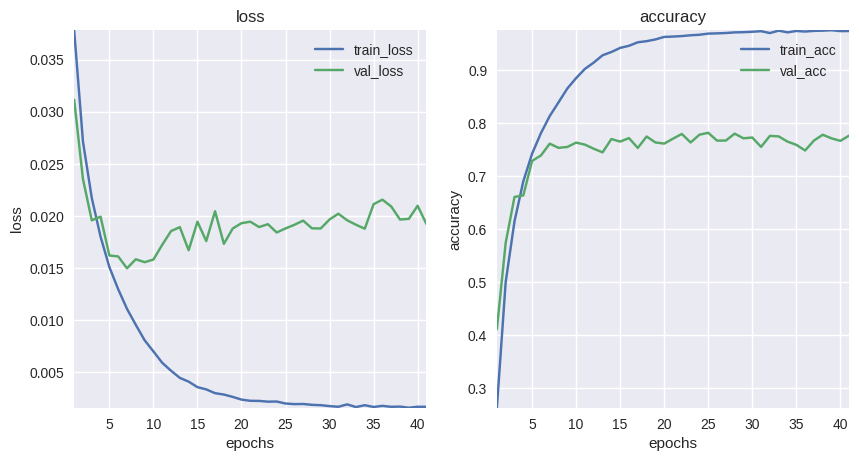

epoch:41
train_acc:48669
val_acc:7761
avg_train_loss:0.001662367698699236
avg_val_loss:0.019229222226142883
avg_train_acc:0.97338
avg_val_acc:0.7761
1epoch_time:66.89521074295044[sec]


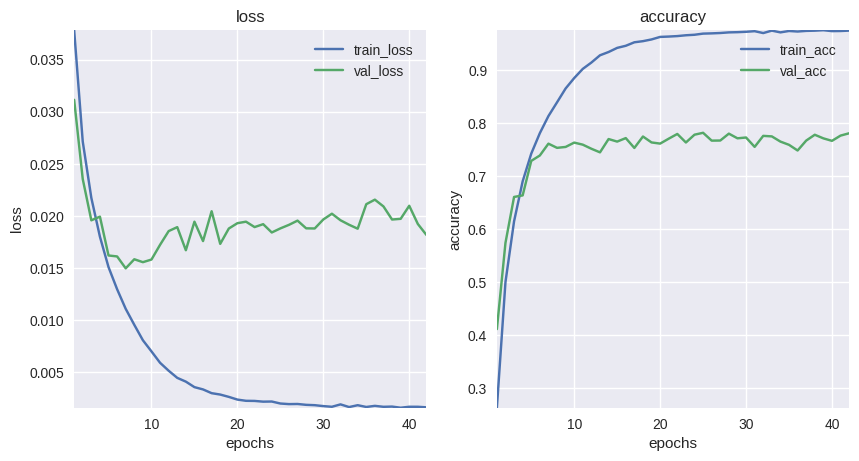

epoch:42
train_acc:48707
val_acc:7805
avg_train_loss:0.001611108107615728
avg_val_loss:0.018172150346636773
avg_train_acc:0.97414
avg_val_acc:0.7805
1epoch_time:66.7965338230133[sec]


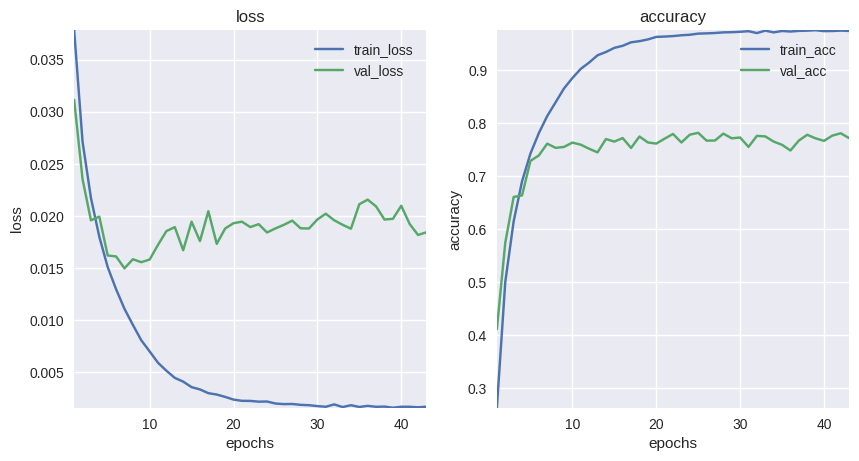

epoch:43
train_acc:48675
val_acc:7713
avg_train_loss:0.0016714623298309742
avg_val_loss:0.018430044512450696
avg_train_acc:0.9735
avg_val_acc:0.7713
1epoch_time:66.83848261833191[sec]


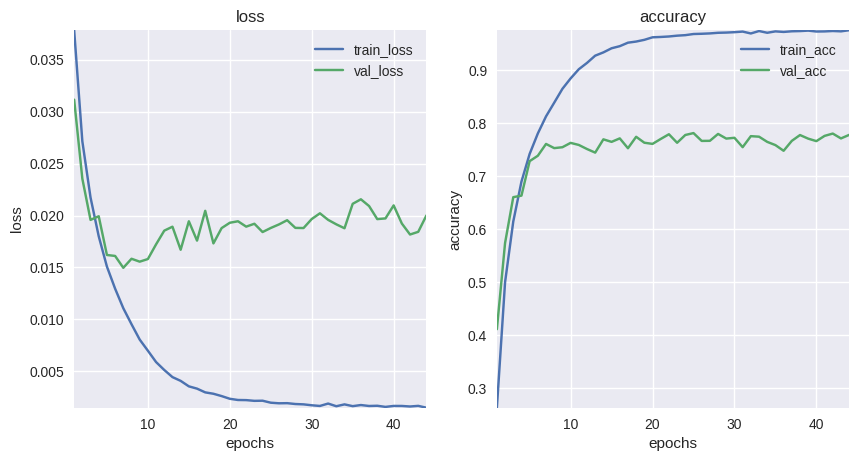

epoch:44
train_acc:48781
val_acc:7780
avg_train_loss:0.0014927659557154402
avg_val_loss:0.020008856841921805
avg_train_acc:0.97562
avg_val_acc:0.778
1epoch_time:66.92123603820801[sec]


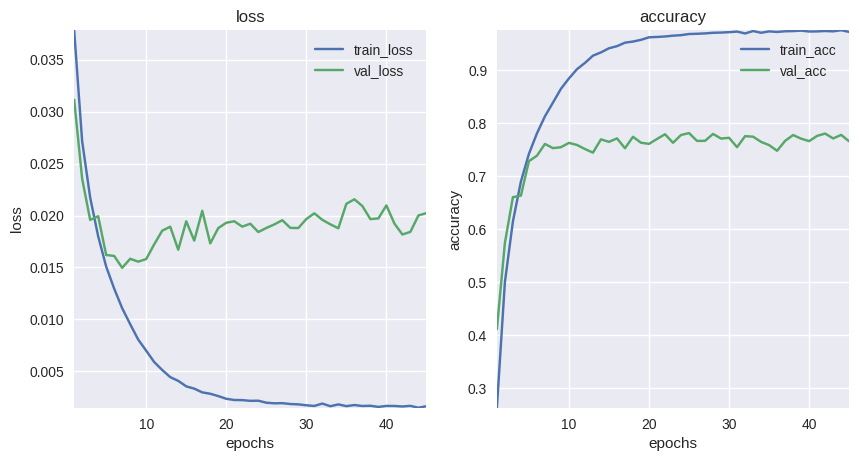

epoch:45
train_acc:48623
val_acc:7658
avg_train_loss:0.0016401539001963102
avg_val_loss:0.020233177234232427
avg_train_acc:0.97246
avg_val_acc:0.7658
1epoch_time:66.9134464263916[sec]


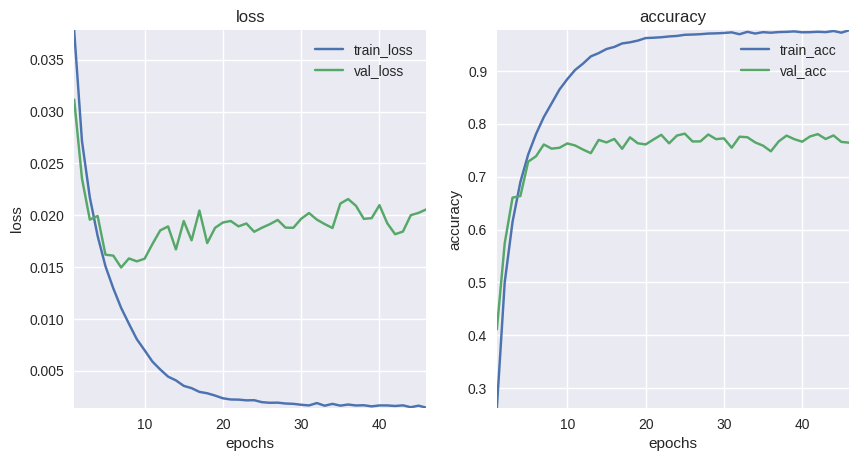

epoch:46
train_acc:48855
val_acc:7643
avg_train_loss:0.0014428484987583942
avg_val_loss:0.020574254474043846
avg_train_acc:0.9771
avg_val_acc:0.7643
1epoch_time:66.9015462398529[sec]


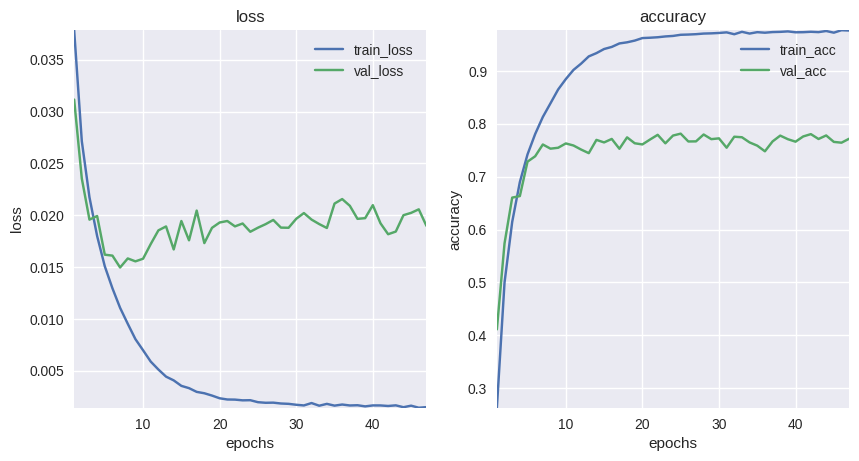

epoch:47
train_acc:48826
val_acc:7718
avg_train_loss:0.0014982936150627212
avg_val_loss:0.018981460738182066
avg_train_acc:0.97652
avg_val_acc:0.7718
1epoch_time:66.88898062705994[sec]


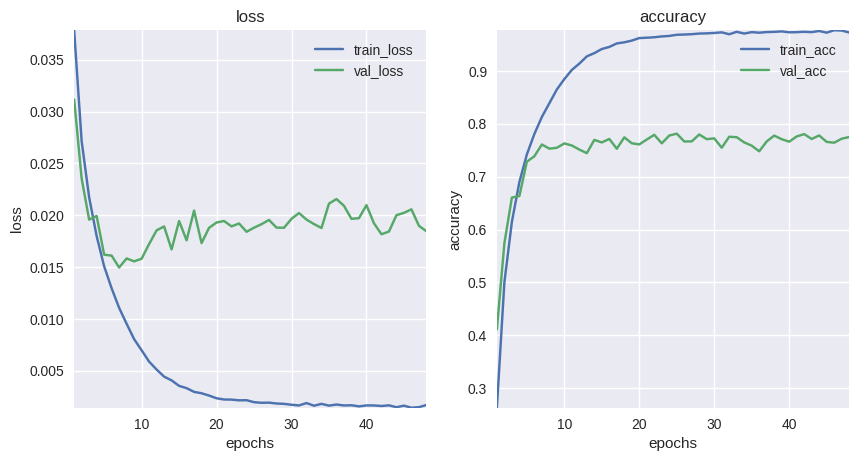

epoch:48
train_acc:48642
val_acc:7750
avg_train_loss:0.0017057948669185862
avg_val_loss:0.018459281921386718
avg_train_acc:0.97284
avg_val_acc:0.775
1epoch_time:66.94476699829102[sec]


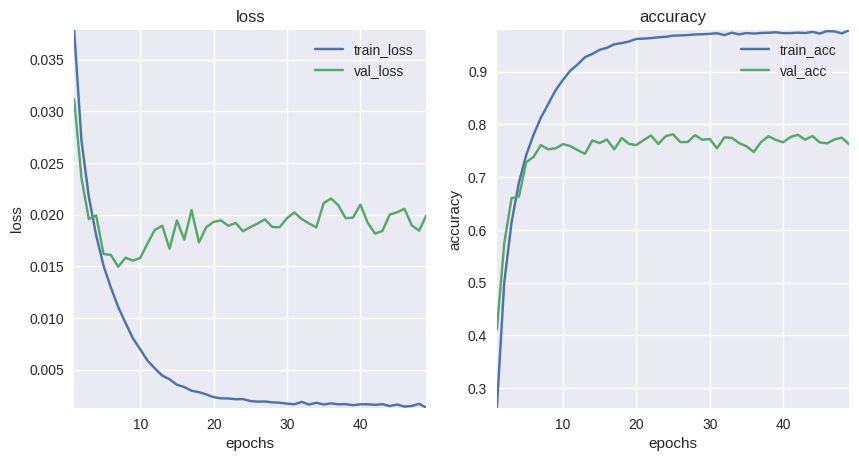

epoch:49
train_acc:48939
val_acc:7624
avg_train_loss:0.0013302797350147738
avg_val_loss:0.01995215319991112
avg_train_acc:0.97878
avg_val_acc:0.7624
1epoch_time:66.87756705284119[sec]


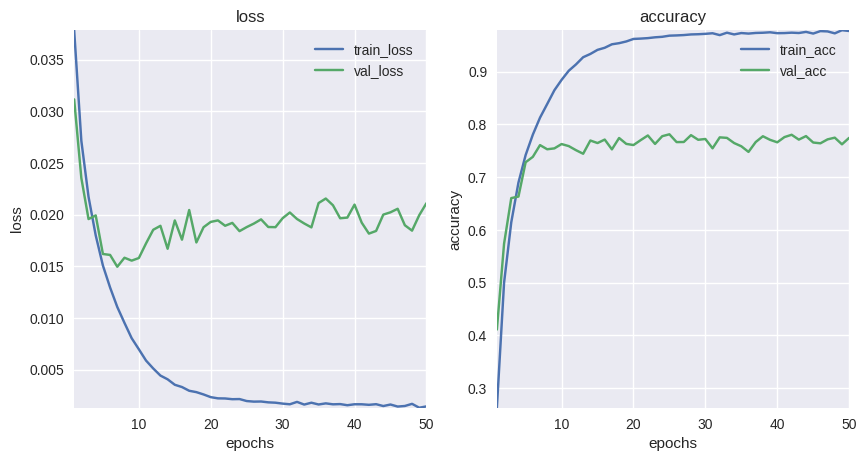

epoch:50
train_acc:48867
val_acc:7747
avg_train_loss:0.0014580347111553418
avg_val_loss:0.021111496010422708
avg_train_acc:0.97734
avg_val_acc:0.7747
1epoch_time:66.96691703796387[sec]
total:3386.431149482727[sec]


In [0]:
start_total = time.time()

# 50 epochs
num_epochs = 50

# 最後にlossとaccuracyをプロットするためのリスト
epoch_list = []
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    # エポックごとに初期化
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    start_epoch = time.time()
    
    # train==============================
    # 訓練モードへ切り替え
    net.train()
    # ミニバッチで分割して読み込む
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # 勾配をリセット
        optimizer.zero_grad()
        # 順伝搬の計算
        outputs = net(images)
        # lossの計算
        loss = criterion(outputs, labels)
        # lossのミニバッチ分を溜め込む
        train_loss += loss.item()
        # accuracyのミニバッチ分を溜め込む
        # 正解ラベル（labels）と予測値のtop1（outputs.max(1))が合っている場合に１を加算していく。
        train_acc += (outputs.max(1)[1] == labels).sum().item()
        # 逆伝搬の計算
        loss.backward()
        # 重みの更新
        optimizer.step()
        
    # １epoch中での平均lossと平均accuracyを計算
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    # validation==============================
    # 訓練モードへ切り替え
    net.eval()
    # 評価時に必要のない計算が走らせない設定
    with torch.no_grad():
        # ミニバッチで分割して読み込む
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # 順伝搬の計算
            outputs = net(images)
            # lossの計算
            loss = criterion(outputs, labels)
            # lossのミニバッチ分を溜め込む
            val_loss += loss.item()
            # accuracyのミニバッチ分を溜め込む
            val_acc += (outputs.max(1)[1] == labels).sum().item()
            
    # １epoch中での平均lossと平均accuracyを計算
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)
    
    # show outputs==============================
    # グラフプロット用のリストに格納（１epoch毎にデータ更新）
    epoch_list.append(epoch+1)
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)
    # 諸出力表示
    show_figure(epoch_list, train_loss_list, val_loss_list, train_acc_list, val_acc_list) 
    print('epoch:{0}'.format(epoch+1))
    print("train_acc:{0}".format(train_acc))
    print("val_acc:{0}".format(val_acc))
    print("avg_train_loss:{0}".format(avg_train_loss))
    print("avg_val_loss:{0}".format(avg_val_loss))
    print("avg_train_acc:{0}".format(avg_train_acc))
    print("avg_val_acc:{0}".format(avg_val_acc))
    end_epoch = time.time() - start_epoch
    print ("1epoch_time:{0}".format(end_epoch) + "[sec]") 
    
end_total = time.time() - start_total
print ("total:{0}".format(end_total) + "[sec]")

In [0]:
now = datetime.now()
JAPAN = timezone(timedelta(hours=+9), 'JAPAN')
foldername = str('{0:%Y%m%d}'.format(datetime.now(JAPAN))) + '-' + str('{0:%H%M%S}'.format(datetime.now(JAPAN)))
print(foldername)
print('./' + foldername + '/train')

20190219-130126
./20190219-130126/train


# save experiment